# Vision Transformer from scratch: training end to end

This notebook implements the Vision Transformer architecture described in the ViT paper "AN IMAGE IS WORTH 16X16 WORDS:
TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE" and trains it end to end.

ViT converts an image into a sequence of patch tokens, then applies a standard Transformer encoder.
If an image is split into $N$ patches and each patch token has dimension $D$, the token sequence has shape $[B, N+1, D]$ because we also prepend a learnable class token $[\mathrm{CLS}]$.


<img src="assets/vit_architecture.png" alt="VIT Architecture" width="900" height="600">


## Imports and device

We import PyTorch, torchvision for data, and matplotlib for visualization.
We also choose a compute device. Training a ViT-Base model can be slow on CPU, so a GPU helps.


In [1]:
import math
from typing import Tuple, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt
from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


/Users/amit/Documents/Projects/vision-transformer-pytorch/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cpu


## Dataset and preprocessing (small subset)

The ViT-Base/16 model in the paper is trained on $224 \times 224$ images with patch size $P=16$.
That produces $(224/16)^2 = 14^2 = 196$ patch tokens, and with the class token the sequence length is $197$.

To match the ViT-Base/16 tokenization, we resize CIFAR-10 images from $32 \times 32$ to $224 \times 224$.


In [2]:
img_size = 224
patch_size = 16

train_tfms = T.Compose([
    T.Resize(img_size),
    T.ToTensor(),
])

test_tfms = T.Compose([
    T.Resize(img_size),
    T.ToTensor(),
])

full_train_ds = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=train_tfms)
full_test_ds  = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=test_tfms)

classes = full_train_ds.classes
print("Classes:", classes)

Files already downloaded and verified
Files already downloaded and verified
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


To keep runs fast, we start with a small training and test data set instead of using full dataset.

In [3]:

# Fixed subset for fast experiments
train_indices = torch.randperm(len(full_train_ds))[:200].tolist()
test_indices  = torch.randperm(len(full_test_ds))[:100].tolist()

train_ds = Subset(full_train_ds, train_indices)
test_ds  = Subset(full_test_ds, test_indices)

batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print("Train subset size:", len(train_ds))
print("Test subset size:", len(test_ds))


Train subset size: 200
Test subset size: 100


Check dimension in data loaders

In [4]:
for images, labels in test_loader:
    print(images.shape)
    break

torch.Size([64, 3, 224, 224])


# Check raw pixel value for first image

In [29]:
images[0][0]

tensor([[0.5529, 0.5529, 0.5529,  ..., 0.7647, 0.7647, 0.7647],
        [0.5529, 0.5529, 0.5529,  ..., 0.7647, 0.7647, 0.7647],
        [0.5529, 0.5529, 0.5529,  ..., 0.7647, 0.7647, 0.7647],
        ...,
        [0.8196, 0.8196, 0.8196,  ..., 0.8549, 0.8549, 0.8549],
        [0.8196, 0.8196, 0.8196,  ..., 0.8549, 0.8549, 0.8549],
        [0.8196, 0.8196, 0.8196,  ..., 0.8549, 0.8549, 0.8549]])

## Visualize a batch

We confirm the data pipeline is correct by plotting a grid of images.


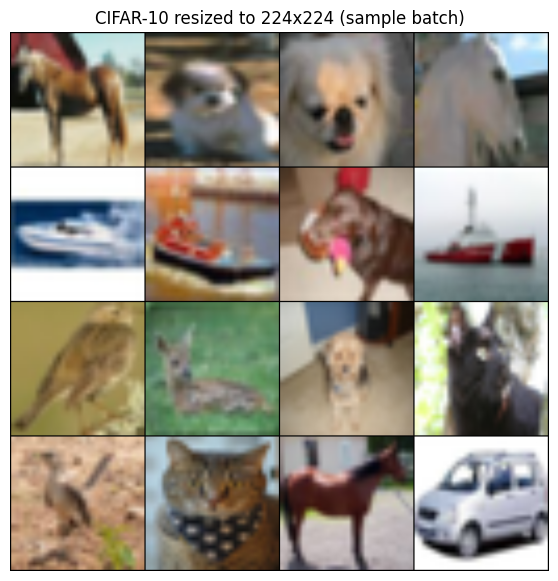

In [20]:
images, labels = next(iter(train_loader))

# Take first 16 images directly
images_vis = images[:16].clamp(0, 1)

fig, ax = plt.subplots(figsize=(7, 7))
grid = torchvision.utils.make_grid(images_vis, nrow=4)
ax.imshow(grid.permute(1, 2, 0))  # CHW -> HWC
ax.set_title("CIFAR-10 resized to 224x224 (sample batch)")
ax.axis("off")
plt.show()

Check classes of first few images

In [6]:
print("Label examples:", [classes[i] for i in labels[:8].tolist()])

Label examples: ['truck', 'horse', 'ship', 'ship', 'truck', 'truck', 'ship', 'horse']


## Patchify: turning images into patch tokens

ViT splits an image into non-overlapping $P \times P$ patches.
Each patch is flattened and treated like a token.

For an image with shape $[B, C, H, W]$ and patch size $P$, the number of patches is:

$$
N = \left(\frac{H}{P}\right)\left(\frac{W}{P}\right)
$$

and each patch has dimension $C P^2$.

We run patchify on a small batch and print shapes.
For $224 \times 224$ and $P=16$, the number of patches is $N=196$.


In [7]:
image_height, image_width = 224, 224
patch_size = 16
total_patches = (image_height/patch_size) * (image_width/patch_size)
print("Total number of patches", int(total_patches))

Total number of patches 196


Visualize convolution operation her https://ezyang.github.io/convolution-visualizer/

### What `nn.Conv2d` Does

`nn.Conv2d` applies a **sliding window operation** over an input image to produce **learned feature maps**.

At each spatial location, it:
1. Looks at a small region of the input (defined by `kernel_size`)
2. Uses a set of **learned filters** that span **all input channels**
3. Computes weighted sums (+ bias)
4. Outputs one value per filter

Each **output channel** corresponds to **one filter**, so `out_channels` controls how many features are produced.

In the context of Vision Transformers:
- `kernel_size = patch_size`
- `stride = patch_size`

This makes `Conv2d`:
- Split the image into **non-overlapping patches**
- Linearly **project each patch** into a fixed-size embedding vector

Effectively, it performs **patch extraction + linear projection in one operation**.


In [24]:
def patchify(x: torch.Tensor, patch_size = 16):
    print("Input tensor shape (B, C, H, W):", x.shape)

    ''' Convert input pixels to a projection.
    Projection = a learned linear mapping that converts a raw image patch into a fixed-dimensional 
    feature vector suitable for a transformer.
    New vector will not be a raw pixel value but it will be a learned representation.'''

    proj = nn.Conv2d(in_channels=3, out_channels=768,
                     kernel_size=patch_size, stride=patch_size)
    x = proj(x)
    print("After Conv2d patch projection (B, D, H', W'):", x.shape)

    # Flatten spatial grid into patch count
    x = x.flatten(2)
    print("After flattening spatial dims → patches (B, D, N):", x.shape)

    # Transformer expects: batch, sequence_length, embedding_dim
    x = x.transpose(1, 2)
    print("After transpose for transformer input (B, N, D):", x.shape)

    return x

patches = patchify(images, patch_size=patch_size)

Input tensor shape (B, C, H, W): torch.Size([64, 3, 224, 224])
After Conv2d patch projection (B, D, H', W'): torch.Size([64, 768, 14, 14])
After flattening spatial dims → patches (B, D, N): torch.Size([64, 768, 196])
After transpose for transformer input (B, N, D): torch.Size([64, 196, 768])


Check learned representation vector for first patch

In [32]:
patches[0][0][:10]

tensor([ 0.5139, -0.0140,  0.0764, -0.3361, -0.0989,  0.3188,  0.0528, -0.0678,
        -0.1036,  0.0441], grad_fn=<SliceBackward0>)

## Patch embedding, class token, and positional embedding

After patchifying the image, each patch vector $\mathbf{x}_i$ is linearly projected
into the model dimension $D$:

$$
\mathbf{z}_i = E \mathbf{x}_i + \mathbf{b}
$$

where  
$\mathbf{x}_i \in \mathbb{R}^{3.P.P}$ is the flattened raw pixel vector of patch $i$,  
$E \in \mathbb{R}^{D \times (3.P.P)}$ is the learned projection matrix,  
$\mathbf{b} \in \mathbb{R}^{D}$ is the bias term, and  
$\mathbf{z}_i \in \mathbb{R}^{D}$ is the resulting patch embedding (token).

This converts image patches into transformer-compatible vectors.

ViT prepends a learnable class token and adds learnable positional embeddings:

$$
\mathbf{Z}_0 = [\mathbf{z}_{\mathrm{cls}}; \mathbf{z}_1; \dots; \mathbf{z}_N] + \mathbf{E}_{\mathrm{pos}}
$$

PyTorch layers already include reasonable default initializations, so we do not manually initialize weights here.


In [34]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_chans: int, embed_dim: int):
        super().__init__()
        assert img_size % patch_size == 0, "img_size must be divisible by patch_size"
        self.num_patches = (img_size // patch_size) ** 2

        # patchify + linear projection in one step
        self.proj = nn.Conv2d(in_channels=in_chans, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size)

        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, 1 + self.num_patches, embed_dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B = x.shape[0]

        x = self.proj(x)                       # [B, D, H/P, W/P]
        x = x.flatten(2).transpose(1, 2)       # [B, N, D]

        cls = self.cls_token.expand(B, -1, -1) # [B, 1, D]
        x = torch.cat([cls, x], dim=1)         # [B, 1+N, D]

        x = x + self.pos_embed[:, : x.size(1)]
        return x

pe = PatchEmbedding(img_size=img_size, patch_size=patch_size, in_chans=3, embed_dim=768)

with torch.inference_mode():
    tok = pe(images)
print("PatchEmbedding output:", tok.shape)  # expected [64, 197, 768]

print("Initail token values", tok[0][0][:10])
print("Other token values", tok[1][1][:10])

PatchEmbedding output: torch.Size([64, 197, 768])
Initail token values tensor([ 1.9837, -0.3786, -0.0676,  2.5765, -0.8506, -1.3071, -1.7766,  0.6425,
        -0.3635, -1.9380])
Other token values tensor([ 0.7916,  0.1837, -0.1652, -1.1156, -0.9819, -0.7082,  0.5858, -0.5310,
        -0.4471,  0.4585])


## Attention: the core idea

Self-attention lets each token mix information from all other tokens in the sequence.

Scaled dot-product attention:

$$
\mathrm{Attention}(\mathbf{Q},\mathbf{K},\mathbf{V}) =
\mathrm{softmax}\left(\frac{\mathbf{Q}\mathbf{K}^\top}{\sqrt{d_k}}\right)\mathbf{V}
$$

The implementation below uses explicit matrix multiplication `q @ k.transpose(-2, -1)`.


In [30]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, dropout: float = 0.0):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, q: torch.Tensor, k: torch.Tensor, v: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        d_k = q.shape[-1]

        # k.transpose(-2, -1) turns [B, h, N, d] into [B, h, d, N] so we can do Q @ K^T
        scores = q @ k.transpose(-2, -1)  # [B, h, N, N]
        scores = scores / math.sqrt(d_k)  # scaling keeps scores in a good numeric range

        attn = F.softmax(scores, dim=-1)  # attention weights over keys
        attn = self.dropout(attn)

        out = attn @ v  # weighted sum of values
        return out, attn

attn_layer = ScaledDotProductAttention(dropout=0.0)
q = torch.randn(64, 12, 197, 64)
k = torch.randn(64, 12, 197, 64)
v = torch.randn(64, 12, 197, 64)
with torch.inference_mode():
    out, attn = attn_layer(q, k, v)
print("ScaledDotProductAttention out:", out.shape)
print("ScaledDotProductAttention attn:", attn.shape)


ScaledDotProductAttention out: torch.Size([64, 12, 197, 64])
ScaledDotProductAttention attn: torch.Size([64, 12, 197, 197])


## Multi-head self-attention

Multi-head attention runs $h$ attention operations in parallel.
Each head works in a subspace of size $d = D/h$, then heads are concatenated and projected.

The class below returns attention maps for visualization.


In [11]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, attn_dropout: float = 0.0, proj_dropout: float = 0.0):
        super().__init__()
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.qkv = nn.Linear(embed_dim, 3 * embed_dim)  # one projection for Q, K, V
        self.attn = ScaledDotProductAttention(dropout=attn_dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)     # output projection
        self.proj_dropout = nn.Dropout(proj_dropout)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        B, N, D = x.shape

        qkv = self.qkv(x)              # [B, N, 3D]
        q, k, v = qkv.chunk(3, dim=-1) # each is [B, N, D]

        q = q.view(B, N, self.num_heads, self.head_dim)
        k = k.view(B, N, self.num_heads, self.head_dim)
        v = v.view(B, N, self.num_heads, self.head_dim)

        # transpose moves the head dimension before sequence length so attention is computed per head
        q = q.transpose(1, 2)  # [B, h, N, d]
        k = k.transpose(1, 2)  # [B, h, N, d]
        v = v.transpose(1, 2)  # [B, h, N, d]

        out, attn = self.attn(q, k, v)

        # merge heads back to D
        out = out.transpose(1, 2).contiguous()  # contiguous makes memory layout compatible with view
        out = out.view(B, N, D)

        out = self.proj(out)
        out = self.proj_dropout(out)
        return out, attn

mhsa = MultiHeadSelfAttention(embed_dim=768, num_heads=12)
x = torch.randn(2, 197, 768)
with torch.inference_mode():
    y, a = mhsa(x)
print("MultiHeadSelfAttention out:", y.shape)
print("MultiHeadSelfAttention attn:", a.shape)


MultiHeadSelfAttention out: torch.Size([2, 197, 768])
MultiHeadSelfAttention attn: torch.Size([2, 12, 197, 197])


## MLP inside the encoder

After attention mixes information across tokens, an MLP transforms each token independently:

$$
\mathrm{MLP}(\mathbf{x}) = \mathbf{W}_2 \, \mathrm{GELU}(\mathbf{W}_1 \mathbf{x})
$$

In ViT-Base, hidden size is $4D$.


In [12]:
class MLP(nn.Module):
    def __init__(self, embed_dim: int, mlp_ratio: float = 4.0, dropout: float = 0.0):
        super().__init__()
        hidden_dim = int(embed_dim * mlp_ratio)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, embed_dim)
        self.drop = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

mlp = MLP(embed_dim=768, mlp_ratio=4.0, dropout=0.0)
x = torch.randn(2, 197, 768)
with torch.inference_mode():
    y = mlp(x)
print("MLP out:", y.shape)


MLP out: torch.Size([2, 197, 768])


## Transformer encoder block

A ViT encoder block uses LayerNorm and residual connections:

$$
\mathbf{y} = \mathbf{x} + \mathrm{MHA}(\mathrm{LN}(\mathbf{x}))
$$

$$
\mathbf{z} = \mathbf{y} + \mathrm{MLP}(\mathrm{LN}(\mathbf{y}))
$$


In [13]:
class EncoderBlock(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, mlp_ratio: float = 4.0,
                 attn_dropout: float = 0.0, dropout: float = 0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads, attn_dropout=attn_dropout, proj_dropout=dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_ratio=mlp_ratio, dropout=dropout)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        y, attn = self.attn(self.norm1(x))
        x = x + y
        y = self.mlp(self.norm2(x))
        x = x + y
        return x, attn

blk = EncoderBlock(embed_dim=768, num_heads=12, mlp_ratio=4.0, dropout=0.0)
x = torch.randn(2, 197, 768)
with torch.no_grad():
    y, a = blk(x)
print("EncoderBlock out:", y.shape)
print("EncoderBlock attn:", a.shape)


EncoderBlock out: torch.Size([2, 197, 768])
EncoderBlock attn: torch.Size([2, 12, 197, 197])


## MLP head for classification

The head maps the final $[\mathrm{CLS}]$ token embedding to class logits.
If `representation_size=None`, it is a single linear layer.


In [14]:
class MLPHead(nn.Module):
    def __init__(self, embed_dim: int, num_classes: int, representation_size: Optional[int] = None):
        super().__init__()
        self.representation_size = representation_size

        if representation_size is None:
            self.pre_logits = nn.Identity()
            self.head = nn.Linear(embed_dim, num_classes)
        else:
            self.pre_logits = nn.Linear(embed_dim, representation_size)
            self.act = nn.Tanh()
            self.head = nn.Linear(representation_size, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pre_logits(x)
        if self.representation_size is not None:
            x = self.act(x)
        x = self.head(x)
        return x

head = MLPHead(embed_dim=768, num_classes=10, representation_size=None)
cls = torch.randn(2, 768)
with torch.no_grad():
    logits = head(cls)
print("MLPHead logits:", logits.shape)


MLPHead logits: torch.Size([2, 10])


## Vision Transformer (ViT-Base/16)

This model uses:
- patch size $16$
- embedding dimension $768$
- 12 encoder blocks
- 12 attention heads
- MLP ratio $4$

The forward pass returns logits with shape $[B, C]$.


In [15]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        img_size: int = 224,
        patch_size: int = 16,
        in_chans: int = 3,
        num_classes: int = 10,
        embed_dim: int = 768,
        depth: int = 12,
        num_heads: int = 12,
        mlp_ratio: float = 4.0,
        attn_dropout: float = 0.0,
        dropout: float = 0.1,
        representation_size: Optional[int] = None,
    ):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_chans, embed_dim)
        self.pos_drop = nn.Dropout(dropout)
        self.blocks = nn.ModuleList([
            EncoderBlock(embed_dim, num_heads, mlp_ratio, attn_dropout=attn_dropout, dropout=dropout)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = MLPHead(embed_dim, num_classes, representation_size=representation_size)

    def forward(self, x: torch.Tensor, return_attn: bool = False):
        x = self.patch_embed(x)
        x = self.pos_drop(x)

        attn_maps = []
        for blk in self.blocks:
            x, attn = blk(x)
            attn_maps.append(attn)

        x = self.norm(x)
        cls_token = x[:, 0]
        logits = self.head(cls_token)

        if return_attn:
            return logits, attn_maps
        return logits

vit = VisionTransformer(img_size=img_size, patch_size=patch_size, num_classes=10).to(device)
xb, _ = next(iter(train_loader))
with torch.no_grad():
    logits = vit(xb.to(device)[:2])
print("VisionTransformer logits:", logits.shape)


VisionTransformer logits: torch.Size([2, 10])


## Parameter count

We report total parameters and trainable parameters, and also show the count in millions.


In [16]:
trainable_params = sum(p.numel() for p in vit.parameters() if p.requires_grad)
print(f"Trainable parameters (millions): {trainable_params/1e6:.2f}M")


Trainable parameters (millions): 85.81M


## Accuracy function

Accuracy is the fraction of correct predictions computed from logits using $\arg\max$.


In [17]:
def accuracy(logits: torch.Tensor, targets: torch.Tensor) -> float:
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()


## Training for 2 epochs

Important training operations:
- Forward pass: compute logits from inputs.
- `loss.backward()`: compute gradients for all parameters.
- `optimizer.step()`: update parameters using gradients.
- Scheduler: update learning rate over time.


In [18]:
def train_one_epoch(model: nn.Module, loader: DataLoader, optimizer, criterion, epoch: int) -> float:
    model.train()
    running_loss = 0.0

    for step, (x, y) in enumerate(loader):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)  # clears old gradients
        logits = model(x)                      # forward pass
        loss = criterion(logits, y)            # compute loss
        loss.backward()                        # backward pass computes gradients
        optimizer.step()                       # update parameters

        running_loss += loss.item()

        if (step + 1) % 50 == 0:
            print(f"Epoch {epoch} Step {step+1}/{len(loader)} Train Loss {loss.item():.4f}")

    return running_loss / len(loader)


In [19]:
@torch.inference_mode()
def evaluate(model: nn.Module, loader: DataLoader, criterion) -> Tuple[float, float]:
    model.eval()
    total_loss = 0.0
    total_acc = 0.0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item()
        total_acc += accuracy(logits, y)

    return total_loss / len(loader), total_acc / len(loader)


## Optimizer, scheduler, and run training

- AdamW updates parameters using adaptive moments and weight decay.
- CosineAnnealingLR changes the learning rate using a cosine schedule across epochs.

We train for 2 epochs and record metrics.


In [20]:
from time import time

model = vit
lr = 3e-4
weight_decay = 0.05
epochs = 5

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

history = {"train_loss": [], "test_loss": [], "test_acc": []}

start = time()
for epoch in range(1, epochs + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, epoch)
    test_loss, test_acc = evaluate(model, test_loader, criterion)
    scheduler.step()

    history["train_loss"].append(train_loss)
    history["test_loss"].append(test_loss)
    history["test_acc"].append(test_acc)

    current_lr = optimizer.param_groups[0]["lr"]
    print(f"Epoch {epoch}: train_loss={train_loss:.4f} test_loss={test_loss:.4f} test_acc={test_acc*100:.2f}% lr={current_lr:.6f}")

print(f"Done in {(time()-start)/60:.2f} minutes")


Epoch 1 Step 10/313 Train Loss 2.5998
Epoch 1 Step 20/313 Train Loss 2.4314
Epoch 1 Step 30/313 Train Loss 2.3322
Epoch 1 Step 40/313 Train Loss 2.2904
Epoch 1 Step 50/313 Train Loss 2.3383
Epoch 1 Step 60/313 Train Loss 2.3003
Epoch 1 Step 70/313 Train Loss 2.4206
Epoch 1 Step 80/313 Train Loss 2.3790
Epoch 1 Step 90/313 Train Loss 2.2591
Epoch 1 Step 100/313 Train Loss 2.3697
Epoch 1 Step 110/313 Train Loss 2.1318
Epoch 1 Step 120/313 Train Loss 2.1388
Epoch 1 Step 130/313 Train Loss 2.0533
Epoch 1 Step 140/313 Train Loss 2.1350
Epoch 1 Step 150/313 Train Loss 2.0484
Epoch 1 Step 160/313 Train Loss 2.1403
Epoch 1 Step 170/313 Train Loss 2.0633
Epoch 1 Step 180/313 Train Loss 2.1346
Epoch 1 Step 190/313 Train Loss 2.0434
Epoch 1 Step 200/313 Train Loss 2.1295
Epoch 1 Step 210/313 Train Loss 1.9585
Epoch 1 Step 220/313 Train Loss 2.1832
Epoch 1 Step 230/313 Train Loss 2.0757
Epoch 1 Step 240/313 Train Loss 2.0723
Epoch 1 Step 250/313 Train Loss 2.0843
Epoch 1 Step 260/313 Train Loss 2.

## Visualize training curves

Plot loss and accuracy over epochs.


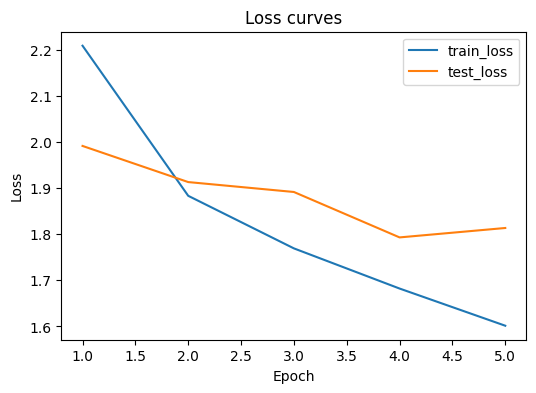

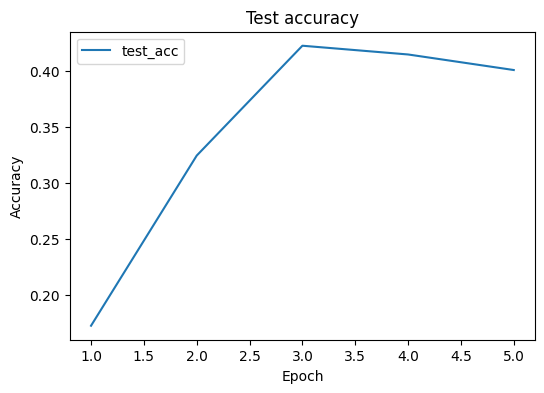

In [21]:
epochs_range = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(6, 4))
plt.plot(list(epochs_range), history["train_loss"], label="train_loss")
plt.plot(list(epochs_range), history["test_loss"], label="test_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss curves")
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(list(epochs_range), history["test_acc"], label="test_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Test accuracy")
plt.show()


## Extract and visualize attention maps

We extract attention matrices from the model and plot one head from one layer.


In [22]:
@torch.no_grad()
def get_attention_maps(model: VisionTransformer, x: torch.Tensor):
    model.eval()
    logits, attn_maps = model(x, return_attn=True)
    return logits, attn_maps


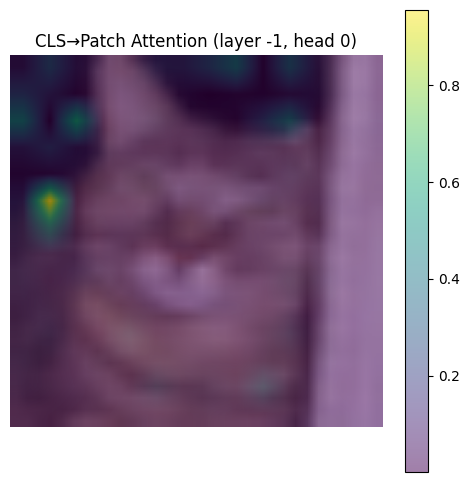

In [23]:
def show_cls_attention_overlay(
    model, image, patch_size=16, layer=-1, head=0, alpha=0.5
):
    """
    image: [1, 3, H, W] tensor (on device)
    Shows CLS->patch attention overlay for a chosen layer/head.
    """
    model.eval()
    with torch.inference_mode():
        logits, attn_maps = model(image, return_attn=True)  # or get_attention_maps(...)

    attn = attn_maps[layer]            # [B, h, T, T] where T = 1 + N
    attn = attn[0, head]               # [T, T]
    cls_to_patches = attn[0, 1:]       # [N] (CLS query -> patch keys)

    H, W = image.shape[-2:]
    gh, gw = H // patch_size, W // patch_size  # grid size, e.g. 14x14
    heat = cls_to_patches.reshape(gh, gw)      # [gh, gw]

    # Normalize for nicer display
    heat = (heat - heat.min()) / (heat.max() - heat.min() + 1e-8)

    # Upsample to image resolution
    heat_up = F.interpolate(
        heat[None, None, ...], size=(H, W), mode="bilinear", align_corners=False
    )[0, 0].cpu()

    img = image[0].detach().cpu().clamp(0, 1).permute(1, 2, 0)  # HWC

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.imshow(heat_up, alpha=alpha)   # overlay
    plt.title(f"CLS→Patch Attention (layer {layer}, head {head})")
    plt.axis("off")
    plt.colorbar()
    plt.show()

# usage
test_images, _ = next(iter(test_loader))
img1 = test_images.to(device)[:1]
show_cls_attention_overlay(model, img1, patch_size=16, layer=-1, head=0, alpha=0.5)


## Prediction helper and sanity check

We convert logits to predicted labels using $\arg\max$.


In [24]:
@torch.no_grad()
def predict_batch(model: nn.Module, x: torch.Tensor) -> torch.Tensor:
    model.eval()
    logits = model(x)
    return logits.argmax(dim=1)


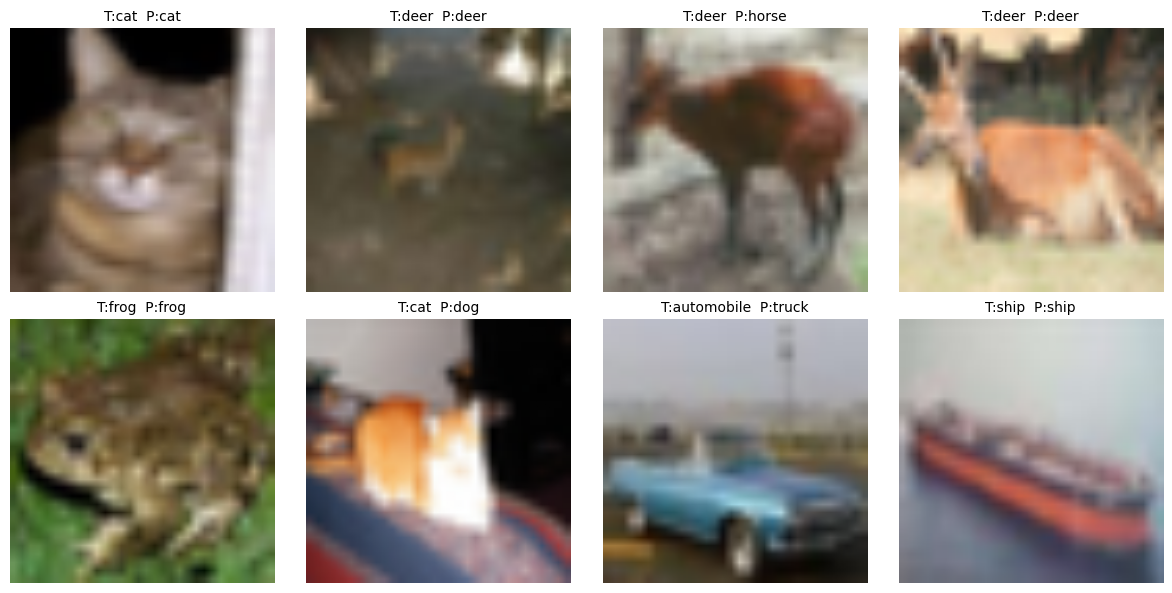

Predictions vs True:
00: pred=       cat  true=       cat
01: pred=      deer  true=      deer
02: pred=     horse  true=      deer
03: pred=      deer  true=      deer
04: pred=      frog  true=      frog
05: pred=       dog  true=       cat
06: pred=     truck  true=automobile
07: pred=      ship  true=      ship


In [25]:
# Grab a batch
images, labels = next(iter(test_loader))
images, labels = images.to(device)[:8], labels[:8]  # keep labels on CPU

# Predict
preds = predict_batch(model, images).cpu()

# Plot (images already in [0,1] from ToTensor)
images_plot = images.cpu().clamp(0, 1)

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(images_plot[i].permute(1, 2, 0))  # CHW -> HWC
    ax.set_title(f"T:{classes[labels[i]]}  P:{classes[preds[i]]}", fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

print("Predictions vs True:")
for i in range(len(preds)):
    print(f"{i:02d}: pred={classes[preds[i]]:>10s}  true={classes[labels[i]]:>10s}")
